<a href="https://colab.research.google.com/github/elbuendiego/ClimateAi_challenge/blob/main/EDA_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis of uke_eggedal_data_challenge.nc

First import required libraries

In [17]:
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Read NetCDF file and take a first look into ints contents 

In [18]:
ds = xr.open_dataset("uke_eggedal_data_challenge.nc")
ds

<xarray.Dataset>
Dimensions:         (station_number: 9, time_flow: 21542, time_weather: 21546)
Coordinates:
  * time_flow       (time_flow) datetime64[ns] 1958-01-04 ... 2016-12-26
  * time_weather    (time_weather) datetime64[ns] 1957-01-01 ... 2015-12-31
  * station_number  (station_number) int64 0 1 2 3 4 5 6 7 8
    lat             float64 ...
    lon             float64 ...
Data variables:
    flow            (time_flow) float64 ...
    temperature     (time_weather, station_number) float64 ...
    precipitation   (time_weather, station_number) float64 ...

Check lat and lon values before dropping them, just in case they provide relevant information

In [4]:
print(f"lat values is {ds.lat.values}")
print(f"lon values is {ds.lon.values}")
ds = ds.drop(["lat","lon"])

lat values is 60.23
lon values is 9.37


Now perform some basic checks on missing data, value ranges and general statistics

In [5]:
# Check for missing values, one variable at a time, saving relevant statistics
stats_list = []
var_list = list(ds.keys())
for var in var_list:
    stats_list.append(ds[var].to_dataframe().describe())
    if xr.ufuncs.isnan(ds[var]).any().values:
        print(f"Variable {var} has missing values.")

# Print a table of variable statistics
stats_df = pd.concat(stats_list, axis=1)
print(stats_df)
if any([stats_df.loc["min", "precipitation"] < 0,
        stats_df.loc["min", "flow"] < 0]):
    print("Warning: precipitation and flow must be >= 0")

               flow    temperature  precipitation
count  21542.000000  193914.000000  193914.000000
mean       6.899912       1.881761       2.189967
std        9.621918       8.697036       4.740461
min        0.000031     -33.799999       0.000000
25%        1.171874      -4.200000       0.000000
50%        3.181420       2.100000       0.000000
75%        8.560671       8.900000       2.400000
max       85.397653      24.000000      73.699997


From the above we know that the meteorological variables do not have the same time-coordinate as "flow". For the EDA we put all variables on the same time coordinate.  

In [6]:
# First select the intersection of time_weather with time_flow
times = np.intersect1d(ds.time_weather.values, ds.time_flow.values)
ds = ds.sel(time_flow=times, time_weather=times)

# Separate ds into dataarrays with same coordinate and merge into dataset
ds = xr.merge([ds["flow"].rename({"time_flow": "time"}), ds[[
              "temperature", "precipitation"]].rename({"time_weather": "time"})])

Auxiliary function to check correlation among temperature/precipitation at different stations. Added for readability.

In [7]:
def met_var_to_df(d_s: xr.Dataset, var_name: str) -> pd.DataFrame:
    '''
    Function that creates a dataframe with columns by station
    from a specified meteorological variable in an xr.Dataset

    input:
        d_s: xr.Dataset with meteorological variables by station
        var_name: str specifying the variable
    output:
        df: pd.DataFrame
    '''
    try:
        assert var_name in ["temperature", "precipitation"]
        n_station = len(d_s.station_number.values)

        # Define variable names for each station
        nm = var_name[0:4]
        names = [f"{nm}_{i}" for i in range(0, n_station)]

        var_df = [d_s[var_name].sel(station_number=i).to_dataframe()[var_name]
                  for i in range(0, n_station)]

        df = pd.concat(var_df, axis=1)
        df.columns = names

        return df
    except AssertionError as err:
        print(
            f"variable name is {var_name}. Must be temperature or precipitation")
        raise err

Now check correlation among temperature/precipitation at different stations

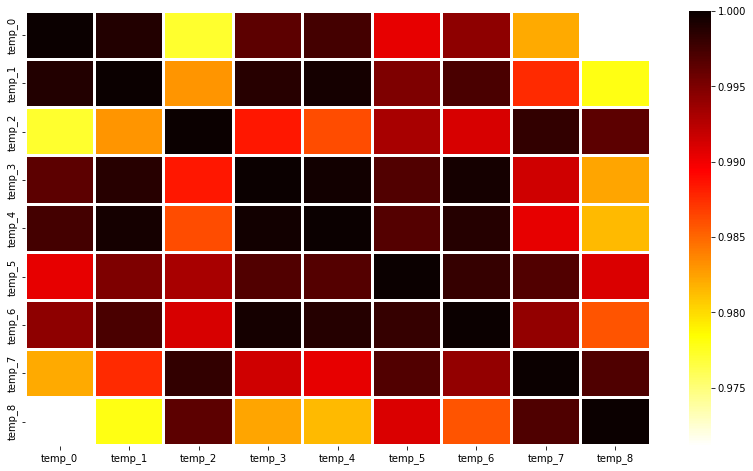

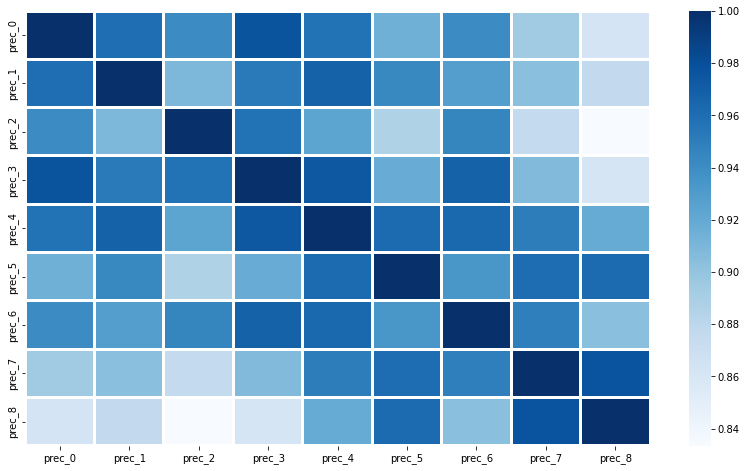

In [8]:
temp_df = met_var_to_df(ds, "temperature")
prec_df = met_var_to_df(ds, "precipitation")

plt.figure(figsize=(14, 8))
sns.heatmap(temp_df.corr(), annot=False, cmap='hot_r', linewidths=2)
plt.figure(figsize=(14, 8))
sns.heatmap(prec_df.corr(), annot=False, cmap='Blues', linewidths=2)

View the monthly climatology of each variable. Given that each meteorological variable is highly correlated from station to station, we consider the average among stations  

Climatology of monthly means


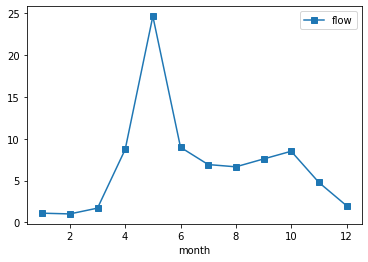

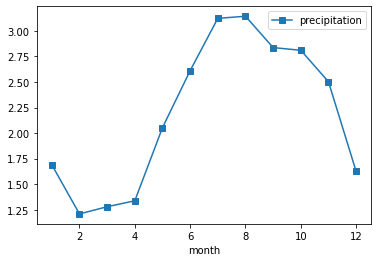

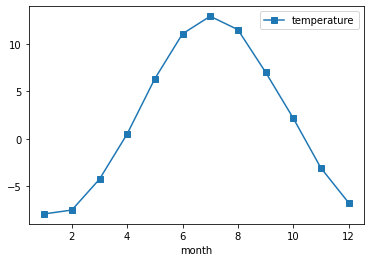

In [9]:
ds_station_avg = ds.mean(dim="station_number")
monthly_avg = ds_station_avg.groupby("time.month").mean("time")

monthly_avg["flow"].to_dataframe().plot(style="s-")
monthly_avg["precipitation"].to_dataframe().plot(style="s-")
monthly_avg["temperature"].to_dataframe().plot(style="s-")
print("Climatology of monthly means")

Just to be sure, check that the flow peak in May is not due to outliers in a given year 

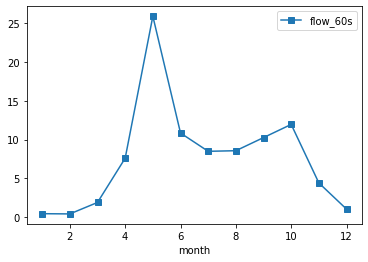

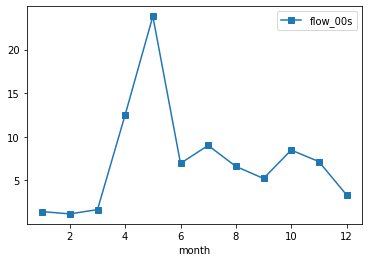

In [10]:
# Check 60s decade
ds_60s=ds_station_avg.where(ds_station_avg.time.dt.year > 1959,drop=True)
ds_60s=ds_60s.where(ds_60s.time.dt.year < 1970,drop=True)
ds_60s = ds_60s.groupby("time.month").mean("time")

# and 00 decade
ds_00s=ds_station_avg.where(ds_station_avg.time.dt.year > 1999,drop=True)
ds_00s=ds_00s.where(ds_00s.time.dt.year < 2010,drop=True)
ds_00s = ds_00s.groupby("time.month").mean("time")

ds_60s["flow"].to_dataframe().rename(
    columns={
        "flow": "flow_60s"}).plot(
            style="s-")
ds_00s["flow"].to_dataframe().rename(
    columns={
        "flow": "flow_00s"}).plot(
            style="s-")

As above, for std

Climatology, monthly std of daily values


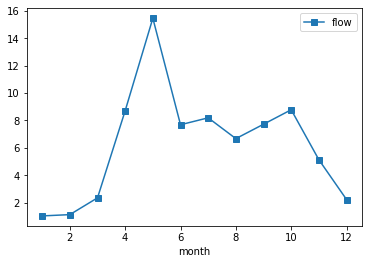

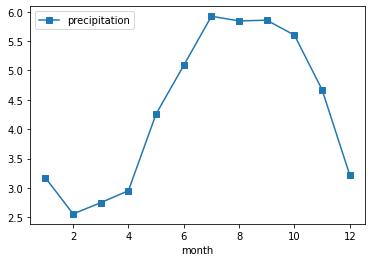

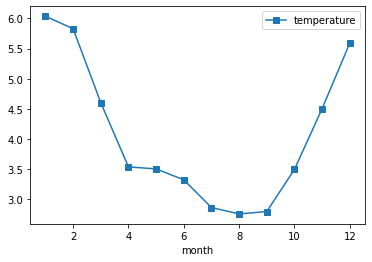

In [11]:
monthly_std = ds_station_avg.groupby("time.month").std("time")

monthly_std["flow"].to_dataframe().plot(style="s-")
monthly_std["precipitation"].to_dataframe().plot(style="s-")
monthly_std["temperature"].to_dataframe().plot(style="s-")
print("Climatology, monthly std of daily values")

The data suggest snow-melt dynamics are at play, as the maximum flow occurs when mean temperatures exceed 0°C, and it is not collocated with the time of maximum precipitation.
 
 
Considering the above, it would be useful to perform cross correlation analyses of monthly anomalies wrt the monthly climatology. Clearly, the annual cycle is crucial, so the analyses will be performed by selecting data one month at a time.
___________________________________________ 

Auxiliary function to create a dataframe with lagged correlations for each month, which will be used to create heatmaps. Each column will indicate the month of the lagged meteorological variable, while indexes (rows) indicate the month of flow data.

In [12]:
def lagged_corr_df(
        d_s: xr.Dataset,
        var_name: str,
        period: str) -> pd.DataFrame:
    '''
    Function that creates a dataframe lagged correlations between "flow"
    and the specified meteorological variable. The correlations are performed
    on monthly or weekly data.

    input:
        d_s: xr.Dataset with monthly/weekly anomalies
        var_name: str specifying the variable
        period: str specifying either monthly or weekly data
    output:
        df: pd.DataFrame
    '''
    try:
        assert var_name in ["temperature", "precipitation"]
        assert period in ["monthly", "weekly"]

        if period == "monthly":
            col_range = 13
        else:
            col_range = 53

        nm = var_name[0:2]
        col_names = [f"{nm}_{i}" for i in range(1, col_range)]
        ind_names = [f"flow_{i}" for i in range(1, col_range)]

        # array to be converted to df
        arr = np.zeros((col_range - 1, col_range - 1))
        aux = np.zeros((2, 57))  # aux for correlation

        for i in range(1, col_range):
            if period == "monthly":
                aux[0, :] = d_s["flow"].isel(
                    time=(d_s.time.dt.month == i)).values[1:]
            else:
                aux[0, :] = d_s["flow"].isel(
                    time=(d_s.time.dt.week == i)).values[1:]
            for j in range(1, col_range):
                if j < i:  # use data from same year as flow
                    low_ind = 1
                    high_ind = 58
                else:
                    low_ind = 0  # go to previous year to remain lagged wrt flow
                    high_ind = 57
                if period == "monthly":
                    aux[1, :] = d_s[var_name].isel(
                        time=(d_s.time.dt.month == j)).values[low_ind:high_ind]
                else:
                    aux[1, :] = d_s[var_name].isel(
                        time=(d_s.time.dt.week == j)).values[low_ind:high_ind]
                arr[i - 1, j - 1] = np.corrcoef(aux)[1, 0]

        df = pd.DataFrame(arr, index=ind_names, columns=col_names)

        return df
    except AssertionError as err:
        print(
            f"variable name is {var_name}. Must be temperature or precipitation")
        raise err

Create xr.dataset of monthly anomalies and plot heatmaps

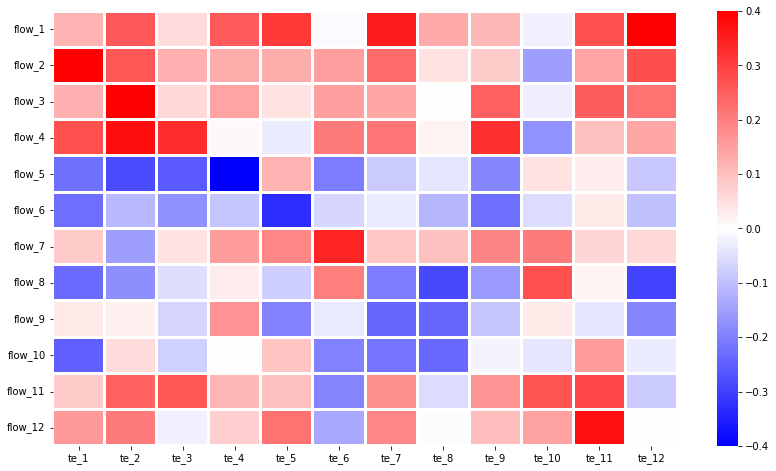

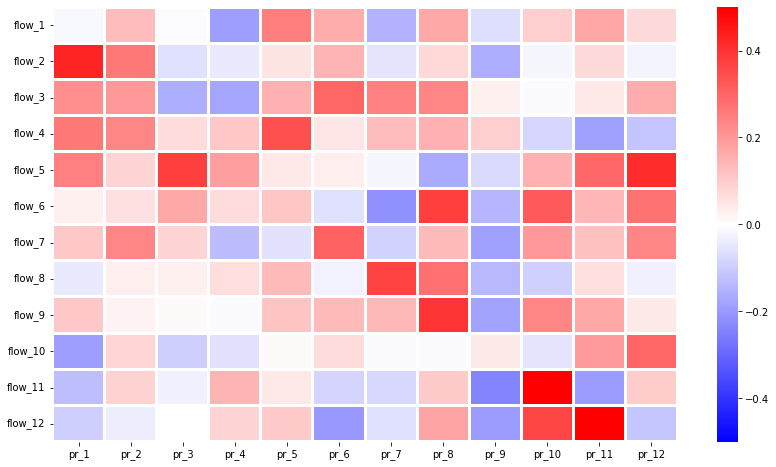

In [13]:
monthly_anomaly = ds_station_avg.resample(
    time="1MS").mean().groupby("time.month") - monthly_avg

temp_df = lagged_corr_df(monthly_anomaly, "temperature", "monthly")
prec_df = lagged_corr_df(monthly_anomaly, "precipitation", "monthly")

plt.figure(figsize=(14, 8))
sns.heatmap(temp_df, annot=False, vmin=-.4, vmax=.4, cmap='bwr', linewidths=2)
plt.figure(figsize=(14, 8))
sns.heatmap(prec_df, annot=False, vmin=-.5, vmax=.5, cmap='bwr', linewidths=2)

The above heatmaps show the following:


1.   1-month lagged temperatures have a relatively large positive impact on the flow registered for months 12, 1, 2, 3, 4; the relationship reverses sign for months 5 and 6. 

> **Possible explanation:** larger temperatures during winter melt snow and increase the flow of the following month; on the other hand, larger temperatures during mid-Spring are associated with snow depletion during previous months due to 1 month lagged autocorrelation (checked below), leaving little snow to melt.


> It is also worth noting the negative correlations present between the flow in May and temperatures during the winter, perhaps indicating that lower temperatures lead to greater snow accumulations, and thus larger flows during peak flows in May.

2.   Regarding precipitation, 1 month lagged correlations are positive and relatively large for flow during months 11, 12, 2; lower positive values are also observed for flow during the summer.



Just to make sure that 1 month lagged temperature autocorrelations are relatively large (see text above; more robust statistical analyses might be required to establish significance), computations are performed below for Feb-Mar, Mar-Apr and Apr-May

In [14]:
for i in range(0, 3):
    autocorr = np.corrcoef(
        monthly_anomaly["temperature"].isel(
            time=(
                monthly_anomaly.time.dt.month == i +
                2)),
        monthly_anomaly["temperature"].isel(
            time=(
                monthly_anomaly.time.dt.month == i +
                3)))
    print(f"Autocorrelation for months {i+2} and {i+3} is {autocorr[1,0]}")

Autocorrelation for months 2 and 3 is 0.3546437275763484
Autocorrelation for months 3 and 4 is 0.2554620482575656
Autocorrelation for months 4 and 5 is 0.14124441557308592


Autocorrelations are not high for April-May. It is possible that the negative association between 1 month lagged flow and temperature might be associated with blocking/anticiclones tha lead to warm and dry conditions. This matter will not be further addressed
_____________________________________

Finally, we will consider a cross correlation analysis of weekly data to determine the period of influence corresponding to the 1 month lagged correlations. The flow will only be taken at bi-weekly intervals.

In [15]:
# Compute weekly anomalies, computing first the climatology
weekly_avg = ds_station_avg.assign_coords(
    {"week": ds_station_avg.time.dt.isocalendar()["week"].values})
weekly_avg = weekly_avg.groupby("week").mean(
    "time").groupby("week").mean("week")

weekly_anomaly = ds_station_avg.resample(
    time="1W").mean().groupby("time.week") - weekly_avg

weekly_anomaly

/usr/local/lib/python3.7/dist-packages/xarray/core/accessor_dt.py:383: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  FutureWarning,


<xarray.Dataset>
Dimensions:        (time: 3027)
Coordinates:
  * time           (time) datetime64[ns] 1958-01-05 1958-01-12 ... 2016-01-03
    week           (time) int64 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52 53
Data variables:
    flow           (time) float64 -5.572 -6.358 -6.093 ... -4.168 -3.88 -2.326
    temperature    (time) float64 -12.08 -15.42 -7.668 ... -6.308 -2.225 -8.259
    precipitation  (time) float64 -0.8962 2.162 -0.6097 ... -1.24 -1.287 2.293

Now see weekly lagged correlations. 

Se truncaron las últimas líneas 5000 del resultado de transmisión.
/usr/local/lib/python3.7/dist-packages/xarray/core/accessor_dt.py:383: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/xarray/core/accessor_dt.py:383: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/xarray/core/accessor_dt.py:383: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/xarray/core/accessor_dt.py:383: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/xarray/core/accessor_dt.py:383: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar()

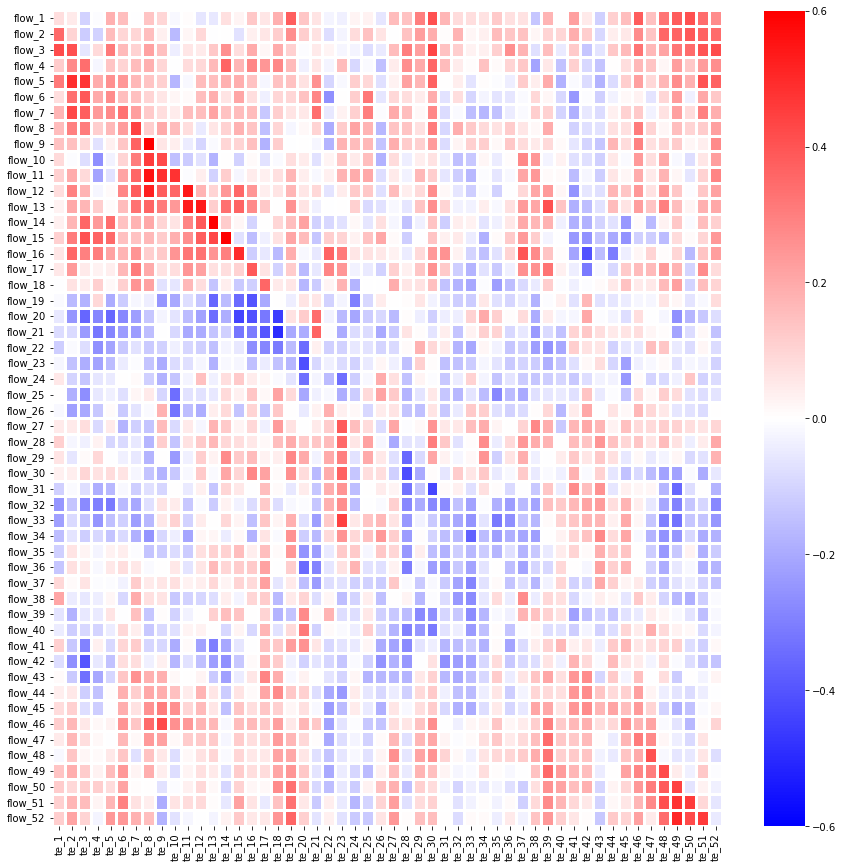

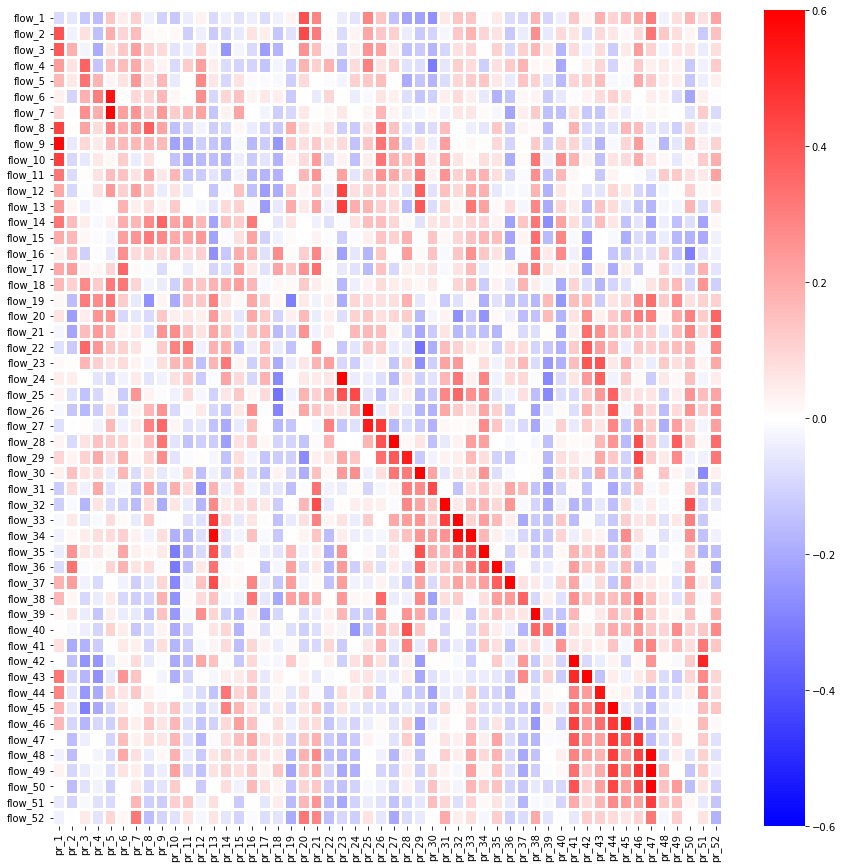

In [16]:
# !!!TODO: Check dt.week warning
temp_df = lagged_corr_df(weekly_anomaly, "temperature", "weekly")
prec_df = lagged_corr_df(weekly_anomaly, "precipitation", "weekly")

plt.figure(figsize=(15, 15))
sns.heatmap(temp_df, annot=False, vmin=-.6, vmax=.6, cmap='bwr', linewidths=2)
plt.figure(figsize=(15, 15))
sns.heatmap(prec_df, annot=False, vmin=-.6, vmax=.6, cmap='bwr', linewidths=2)

The above heatmaps show the following:


1.   There are two distinct regimes: a Winter regime (extending to mid-Spring), where the flow is modulated primarily by temperatures (via snow-melting and its influence on rain vs snow precipitation); a Summer-Autumn regime where the flow seems to be primarily modulated by precipitation.

2.   The period of influence of temperatures on the Winter regime is relatively long (from november onward). It is worth noting that there is a strong signal of negative correlations between the flow in May and temperatures during Winter (probably related to snow accumulation with low Winter temperatures).

3.   The period of influence of precipitation is relatively short during Summer (around 2-3 weeks), incresing significantly during Autumn (October-onward). Hypothesis: temperautre variations due to the passage of frontal systems during Autumn-Winter (see monthly std) favor snowing/melting in elevated areas, a process that has more inertia than rain alone.





Finally, check autocorrelation of flow, to get a sense of time period of flow variations

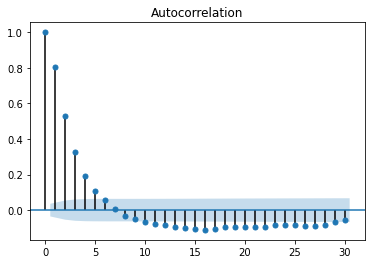

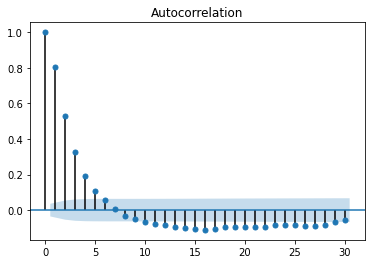

In [20]:
plot_acf(weekly_anomaly.flow.values, lags=30)

The above ACF suggests that 2-3 weeks might give enough information for forecasting. However, the autocorrelation is likely to have strong seasonality, a matter that should be investigated further.
_________________________________

# Conclusions from EDA:


1.   Temperature plays a significant role during Winter and early-Spring as it modulates snow dynamics. In Autumn there might be an interplay with precipitation, with precipitation having a primary role in flow levels.
2.   Precipitation has three distinct regimes: weak but long-lasting influence on the flow during winter-early Spring; strong and short-lasting influence during Summer; strong and long-lasting influence during Autumn.

# Modelling Strategy  


*   Incorporate short-term effects of precipitation and temperature as weekly variables (hoping that temperatures help the model discern if precipitation will actually flow directly or accumulate as snow).
*   Incorporate long-term effects due to snow accumulation as monthly variables.
*   Temperatures will be left as full fields, given that its value determines if precipitation will fall as snow or rain; precipitation and flow will be converted to anomalies.
*   As a first guess, and due to limitations in the number of years, the model be based on anomalies of weekly meteorological variables averaged across stations, as well as the weekly averaged flow anomaly during the weeks previous to the forecast date (include rate of change of weekly flow...)